# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json
from simplegen import SIMPLESequence

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

from unet import UNet
from unet import preprocess_input as pre_une

from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.0.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Functionality
Necessary funcionality is added here

In [3]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

# 6.8) Supervised Euclidean for SIMPLED with fixed image
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/6_8_euclidean'

path_fixed = r'D:\Julian\data\SIMPLED\train\0'
path_train = r'D:\Julian\data\SIMPLED\train'
path_validation = r'D:\Julian\data\SIMPLED\validation'
path_test = r'D:\Julian\data\SIMPLED\test'

width = 224
height = 224

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(224, 224, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
train_gen = SIMPLESequence(path_train, path_fixed,
                           batch_size=4,
                           preprocess_input=pre_une,
                           shuffle=True,
                           multi_channel='fixed')

validation_gen = SIMPLESequence(path_validation, path_fixed,
                                batch_size=4,
                                preprocess_input=pre_une,
                                multi_channel='fixed')

logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
callbacks = [logger, checker]

model.compile(optimizer='adam', loss = utils.msed_loss)

# Training
Run the training.

In [8]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=validation_gen,
          validation_freq=1,
          #use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Train for 840 steps, validate for 180 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shap

840/840 [==============================] - 82s 98ms/step - loss: 722.3557 - val_loss: 609.9671
Epoch 2/100
840/840 [==============================] - 73s 86ms/step - loss: 295.2440 - val_loss: 69.2219
Epoch 3/100
840/840 [==============================] - 71s 84ms/step - loss: 63.9594 - val_loss: 40.3651
Epoch 4/100
840/840 [==============================] - 69s 82ms/step - loss: 43.8902 - val_loss: 134.2030
Epoch 5/100
840/840 [==============================] - 72s 86ms/step - loss: 34.9258 - val_loss: 44.4679
Epoch 6/100
840/840 [==============================] - 72s 86ms/step - loss: 29.1634 - val_loss: 24.8344
Epoch 7/100
840/840 [==============================] - 70s 83ms/step - loss: 26.7894 - val_loss: 35.6561
Epoch 8/100
840/840 [==============================] - 70s 83ms/step - loss: 24.6091 - val_loss: 23.7568
Epoch 9/100
840/840 [==============================] - 69s 82ms/step - loss: 21.0550 - val_loss: 21.3612
Epoch 10/100
840/840 [==============================] - 70s 83m

# Evaluation
Evaluate the trained network

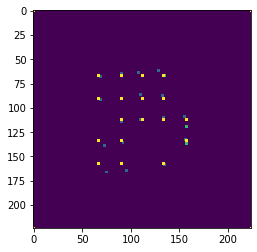

In [9]:
X, y = validation_gen[1]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,25):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)

# 6.9) Supervised Euclidean for SIMPLED with difference image
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Data
Import training images

In [4]:
store_path = 'experiments/6_9_euclidean'

path_fixed = r'D:\Julian\data\SIMPLED\train\0'
path_train = r'D:\Julian\data\SIMPLED\train'
path_validation = r'D:\Julian\data\SIMPLED\validation'
path_test = r'D:\Julian\data\SIMPLED\test'

width = 224
height = 224

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(224, 224, 2))

# Training Preparation
Prepare the settings for training the model.

In [7]:
train_gen = SIMPLESequence(path_train, path_fixed,
                           batch_size=4,
                           preprocess_input=pre_une,
                           shuffle=True,
                           multi_channel='diff')

validation_gen = SIMPLESequence(path_validation, path_fixed,
                                batch_size=4,
                                preprocess_input=pre_une,
                                multi_channel='diff')

logger = CSVLogger(store_path + "/log")
checker = ModelCheckpoint(store_path + "/weights.{epoch:02d}.hdf5",
                          period=10)
callbacks = [logger, checker]

model.compile(optimizer='adam', loss = utils.msed_loss)

# Training
Run the training.

In [8]:
model.fit(train_gen,
          epochs=100,
          callbacks=callbacks,
          validation_data=validation_gen,
          validation_freq=1,
          use_multiprocessing=True,
          workers=10,
          max_queue_size=32)

Train for 840 steps, validate for 180 steps
Epoch 1/100


C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zilkerjn\AppData\Local\Continuum\anaconda3\envs\glotax\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shap

840/840 [==============================] - 81s 96ms/step - loss: 757.4069 - val_loss: 640.1477
Epoch 2/100
840/840 [==============================] - 71s 84ms/step - loss: 439.2043 - val_loss: 150.0228
Epoch 3/100
840/840 [==============================] - 70s 83ms/step - loss: 79.9807 - val_loss: 75.4312
Epoch 4/100
840/840 [==============================] - 71s 85ms/step - loss: 52.3318 - val_loss: 76.3395
Epoch 5/100
840/840 [==============================] - 73s 87ms/step - loss: 39.2280 - val_loss: 65.4678
Epoch 6/100
840/840 [==============================] - 69s 82ms/step - loss: 35.5460 - val_loss: 77.2352
Epoch 7/100
840/840 [==============================] - 69s 82ms/step - loss: 28.2335 - val_loss: 32.8263
Epoch 8/100
840/840 [==============================] - 69s 82ms/step - loss: 27.1812 - val_loss: 22.8728
Epoch 9/100
840/840 [==============================] - 69s 82ms/step - loss: 26.4021 - val_loss: 20.6045
Epoch 10/100
840/840 [==============================] - 70s 83m

# Evaluation
Evaluate the trained network

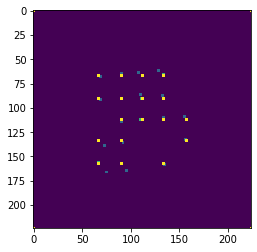

In [9]:
X, y = validation_gen[1]

y_pred = model.predict(X)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

warp = np.zeros((width, height))

for index in range(0,25):
    x_pos = int(y[0, index, 0, 0])
    y_pos = int(y[0, index, 1, 0])
    
    plot_cube(warp, x_pos, y_pos, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y_pos][x_pos]
    uy = uy_field[y_pos][x_pos]
    
    x_pos = int(round(x_pos + ux))
    y_pos = int(round(y_pos + uy))
            
    plot_cube(warp, x_pos, y_pos, 2) #green    
    
    x_pos = int(y[0, index, 0, 1])
    y_pos = int(y[0, index, 1, 1])
    
    plot_cube(warp, x_pos, y_pos, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)